#  Human-Robot Interaction
## Tutorial 2: Robot learning part 2: Mixed Density Networks
**Authors: Pablo Lanillos and Zied Tayeb**

**Date**16/09/2020

**Sources**: 

1. Christopher M. Bishop. Mixed Density Networks (1994). https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf
2.  Lanillos, P., Pages, J. & Cheng, G. (2020). Robot self/other distinction: active inference meets neural networks learning in a mirror. European Conference on Artificial Intelligence (ECAI). https://arxiv.org/abs/2004.05473
3. https://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/




## 1.1 Review of Gaussian function 

## Normal Distribution

Let's plot the PDF (probability density function) of a normal distribution. The function is as follows:

$$\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2} } e^{ -\frac{(x-\mu)^2}{2\sigma^2} }$$

Where $\mu$ and $\sigma$ are the mean and standard deviation.

$\mathcal{N}(x \mid \mu, \sigma^2)$ is the 'relative' likelihood of drawing $x$ from the model parametrised by $\mu$ and $\sigma$.



# Probability density function 

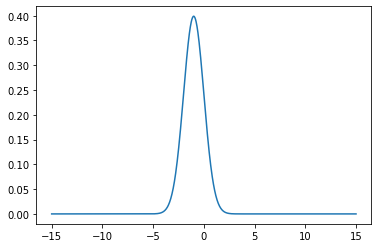

In [2]:
from matplotlib import pyplot as mp
%matplotlib inline
import numpy as np

from matplotlib import pyplot as mp
import numpy as np

def gaussian(x, mu, sig):
    return  1/np.sqrt(2 * np.pi * sig**2) * np.exp(- (x - mu)**2 / (2 * sig**2) )

x_values = np.linspace(-15,15,1000)
for mu, sig in [(-1, 1)]:
    mp.plot(x_values, gaussian(x_values, mu, sig))

mp.show()

#  Probability vs Likelihood: Difference 

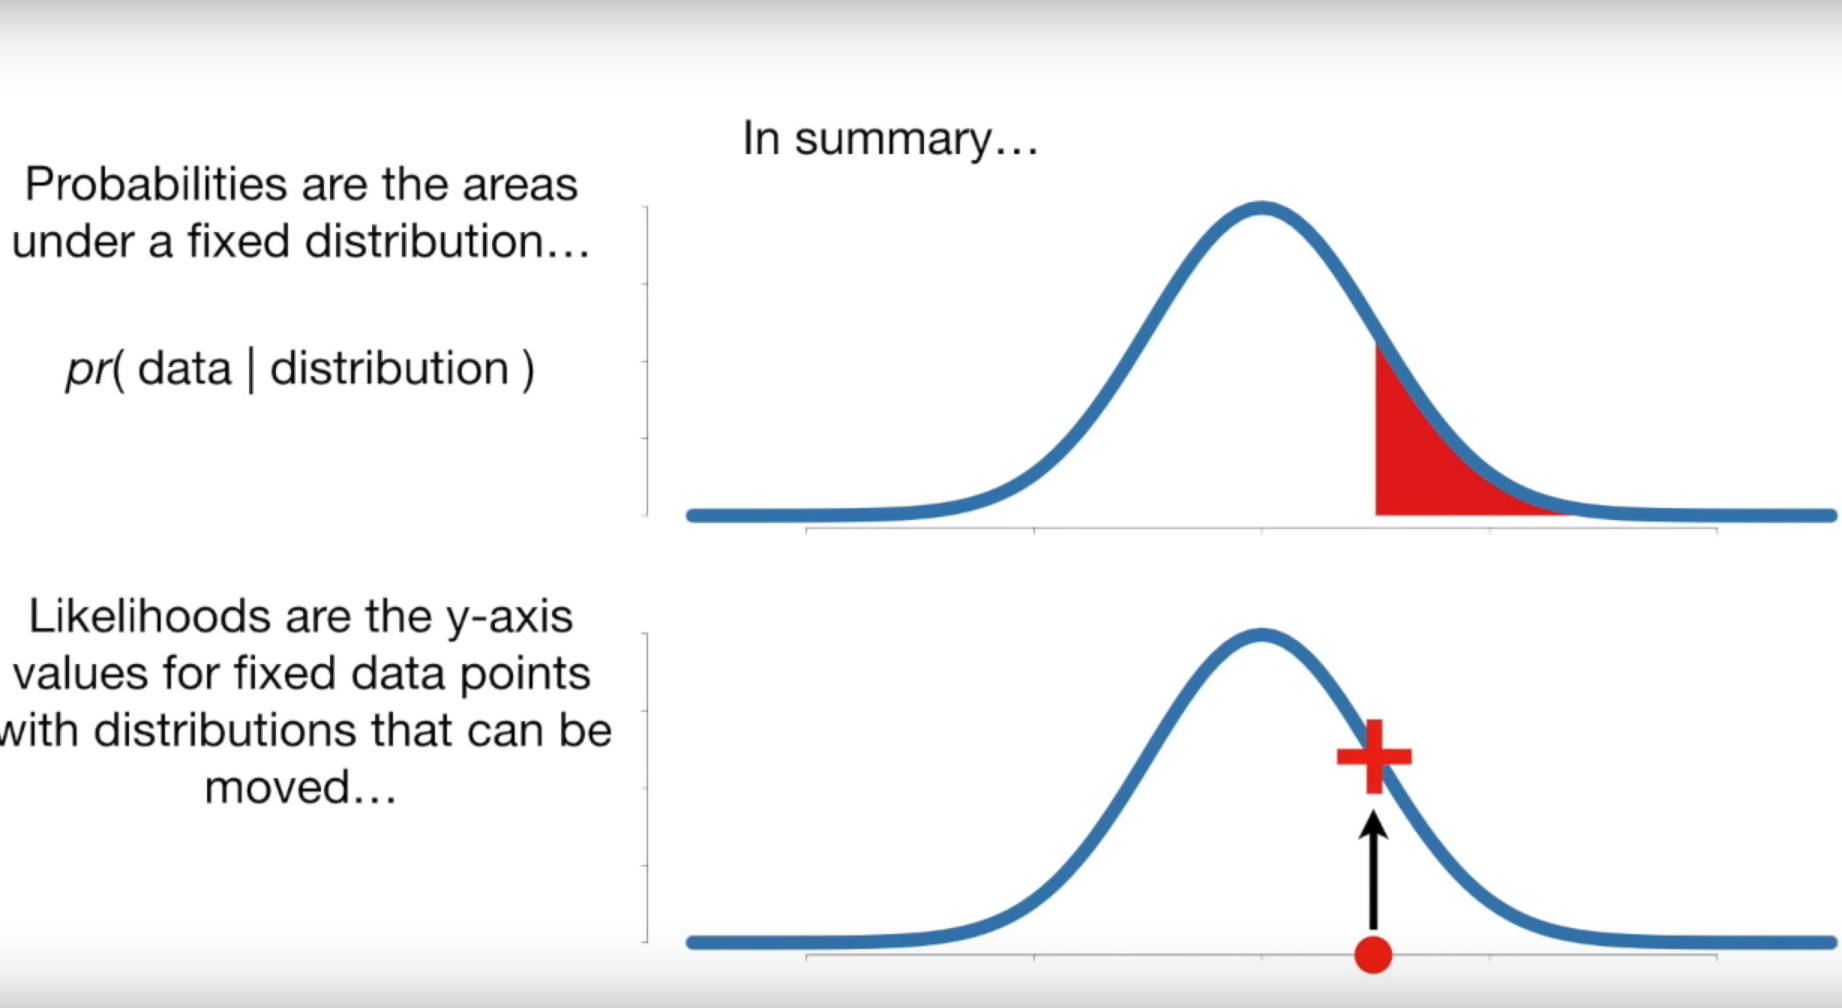

In [3]:
from IPython.display import Image
Image("likelihood.png")


# Bottleneck: Modelling multiple distributions 

Plotting with normal distribution with mu= 0.023237576349757545 and sd= 5.628826428861484


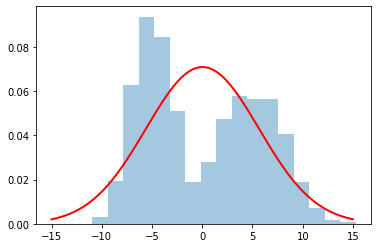

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 
# Let's try modelling two different distributions
s1 = np.random.normal(-5, 2.0, 1000)
s2 = np.random.normal(5, 3.0, 1000)
all_s = np.concatenate([s1, s2])
s_mean = np.mean(all_s) # calculate mean of the whole sample
s_sd = np.std(all_s) # calculate standard deviation of the whole sample.

print("Plotting with normal distribution with mu=", s_mean, "and sd=", s_sd)
sns.distplot(all_s, hist=True, kde=False, norm_hist=True)
sns.lineplot(x_values, gaussian(x_values, s_mean, s_sd), linewidth=2, color='r')
plt.savefig("complex_distribution_hist_and_normal.png", dpi=150, bbox_inches='tight')

## Solution! Mixture Distribution

A mixture distribution lets us mix multiple different distributions together. In our case, we're just considering mixtures of normal models, but you can mix other models as well. The idea is to weight each distribution, so some might be more or less important, and then add them together.


- Suppose that you have $K$ mixture components (number of distributions).
- Then you need $K$ distribution parameters ($\mu$ and $\sigma$), one for each component. Let's call these $\mu_i$ and $\sigma_i$ where $i \in [1, \ldots, K]$.
- Finally we need some weights $\pi_i$, $i \in [1, \ldots, K]$, such that $\sum_{i=1}^K \pi_i = 1$

Now the PDF of this mixture model will be:

$$p(x) = \sum_{i=1}^K \pi_i\mathcal{N}(x \mid \mu, \sigma^2)$$

That is, the likelihood of $x$ occuring in the distribution is the sum of the weighted likelihoods for $x$ from each Guassian model.

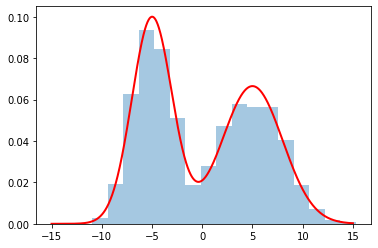

In [5]:
def mixture_of_normals_pdf(x, K, pis, mus, sigmas):
    """PDF for a mixture model of K normal distributions"""
    output = 0
    for i in range(K):
        output += pis[i] *gaussian(x, mus[i], sigmas[i])
    return output


sns.distplot(all_s, hist=True, kde=False, norm_hist=True)
sns.lineplot(x_values, mixture_of_normals_pdf(x_values, 2, [0.5,0.5], [-5,5], [2,3]), linewidth=2, color='r')
plt.savefig("complex_distribution_hist_and_mixture.png", dpi=150, bbox_inches='tight')

### The probability density of the target data is then represented as a linear combination of kernel functions in the form

# 1. What is a mixture density network?



Mixture density network: What, Why and how 

instead of predicting one single value (neural network for regression: One output neuron for regression), we model all uncertainty behind that point. That is basically a mixture density network. Rather than predicting y, you predict a bunch of pi, mean and std . You sample from that to get your real value


We try to do continuous variable prediction under uncertainty! 

Example: If I ask question, I don’t want to hear one single answer but rather a range of answers to assess the probability of each answer! Therefore, we can improve our understanding of the prediction and may even make a better-informed decision!
The probability density of the target data is then represented as a linear combination of kernel functions in the form!

Combining a feedforward network and a mixture model is what we call mixture density network |

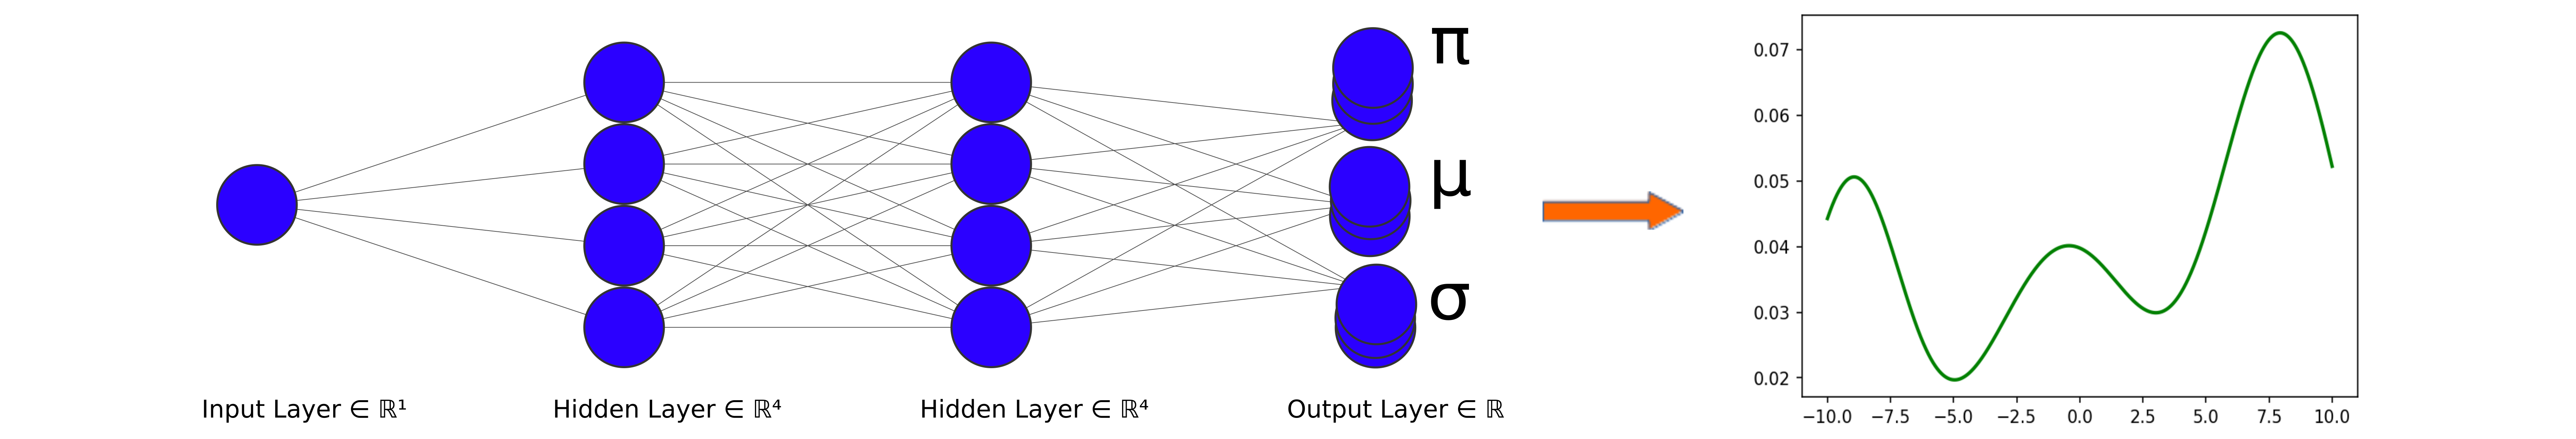

In [6]:
from IPython.display import Image
Image("mdn.png")

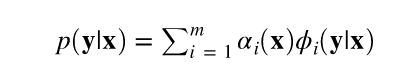

In [7]:
from IPython.display import Image
Image("gaussian_kernel.png")

#  Loss function 

# Probability of target value given an input feature (update the distribution accordingly)

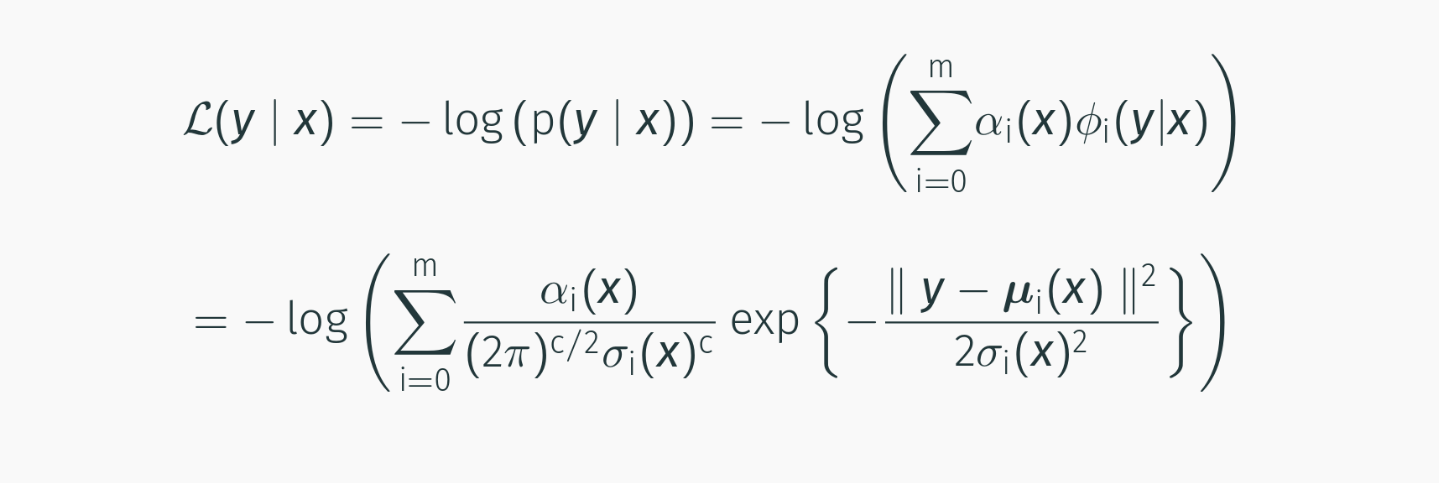

In [8]:
from IPython.display import Image
Image("loss.png")

Where the coefficients sums to 1 $\sum_i \alpha_i = 1$ and the kernel $\phi$ is the Normal distribution.

# Example problem: Single input and multiple outputs  

In [9]:
def generate_data(n_samples):
    noise = np.random.normal(size=(n_samples)) 
    y_data = np.random.uniform(-10.5, 10.5, n_samples) 
    x_data = 7*np.sin(0.75*y_data) + 0.5*y_data + noise
    return x_data, y_data

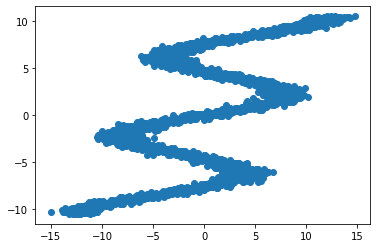

In [10]:
## Generate the data:
NSAMPLE = 3000
# check the tutorial document on how to generate the data and write the function generate_data(n_samples)
x, y = generate_data(NSAMPLE)
# plot. It should output something simliar like:
plt.scatter(x, y)

### Did you try out the Feed-forward for regression (MSE) ?
Write your own FFN to test with the data and plot the **loss function**.

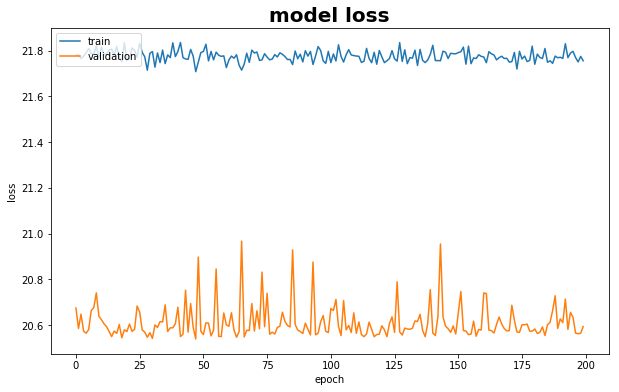

In [11]:
# Example of loss plot
from IPython.display import Image
Image("ffn_loss_mdndata.png")


# Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

In [48]:
#imports
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.nn.functional as F
from torch.autograd import Variable # storing data while learning
from torch.distributions import constraints, multivariate_normal, Normal
from torch.distributions.distribution import Distribution
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


In [49]:
# Program the MDN Network
# NN output is (N_OUTPUT+2)*N_MIXES 

class MDN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        
        #IMPORTANT notes
        # - Use softmax activation for pi  (they need to add up to 1)
        # - Use exponential linear unit for deviations (they should not be negative or close to zero)
        self.pis = nn.Linear(n_hidden, n_gaussians) # Coefficents
        self.mus = nn.Linear(n_hidden, n_gaussians * n_output) # Means
        self.sigmas = nn.Linear(n_hidden, n_gaussians) # Variances / Deviations
        

    def forward(self, x):
        #Program the forward pass
        x = F.relu(self.fc1(x))
        pi = F.softmax(self.pis(x), -1)
        sigma = torch.exp(self.sigmas(x))
        mu = self.mus(x)
        
        return pi, sigma, mu

In [50]:
import sys, math

oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)

# Program the loss function
def gaussian_distribution(y, mu, sigma):
    sigma_1 =  torch.reciprocal(sigma) # sigma^{-1}
    # program the gaussian distribution using torch functions
    result = torch.sub(y, mu)
    result = torch.mul(result, sigma_1)
    result = result.pow(2)/2
    return torch.mul(torch.exp(result), sigma_1) * oneDivSqrtTwoPI
    
def mdn_loss(pi, sigma, mu, y):
    distribution = gaussian_distribution(y, mu, sigma)
    prob = torch.mul(pi, distribution)
    nll = -torch.log(torch.sum(prob, dim=1))
    return torch.mean(nll)

In [51]:
import sys
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * (1.0 / np.sqrt(2.0*np.pi))

def mdn_loss_fn(pi, sigma, mu, y):
    N, K = pi.shape
    _, KT = mu.shape
    NO = int(KT / K)
    losses = Variable(torch.zeros(N))
    for i in range(K): 
        result = gaussian_distribution(y, mu, sigma) * pi
        losses += torch.sum(result, dim=1)
    return torch.mean(-torch.log(losses))

torch.Size([1000, 1])

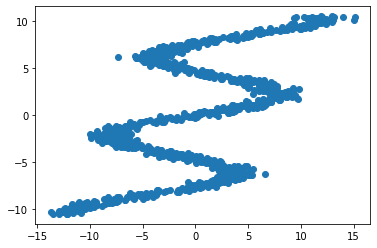

In [52]:
## Generate the data:
n_samples = 1000
# check the tutorial document on how to generate the data and write the function generate_data(n_samples)
x, y = generate_data(n_samples)
# plot. It should output something simliar like:
plt.scatter(x, y)

# instantiate the network, train it and plot the training loss
x = x.reshape(x.shape[0],1) # To transform into a matrix. This is an special case for 1 dimension
y = y.reshape(y.shape[0],1) # To transform into a matrix. This is an special case for 1 dimension

n_input = 1 # x.shape[1]
n_output = 1 # y.shape[1]
N_HIDDEN = 20
N_GAUSSIANS = 5

x_tensor = torch.from_numpy(np.float32(x).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y).reshape(n_samples, n_input))

# torch can only train on Variables
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)
y_variable.shape

In [45]:
# Instantiate the network
model = MDN(n_input=n_input, n_hidden=N_HIDDEN, n_output=n_output, n_gaussians=N_GAUSSIANS)
optimizer = torch.optim.Adam(model.parameters()) # Select optimizer
losses = []

# Write the training function train_mdn(n_epoch=10000)
def train_mdn(network, x_train, y_train, n_epoch=10000):
    for epoch in range(n_epoch):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 500 == 0:
            print(epoch, loss.item())


In [46]:
train_mdn(model, x_variable, y_variable)

0 7.651477813720703
500 2.728605270385742
1000 2.19734263420105
1500 2.0658535957336426
2000 1.8650093078613281
2500 1.726623773574829
3000 1.692130446434021
3500 1.6604408025741577
4000 1.6379289627075195
4500 1.6200741529464722
5000 1.5980379581451416
5500 1.581392526626587
6000 1.5647902488708496
6500 1.551693320274353
7000 1.5428153276443481
7500 1.5352727174758911
8000 1.5771492719650269
8500 1.525172233581543
9000 1.49460768699646
9500 1.504069209098816


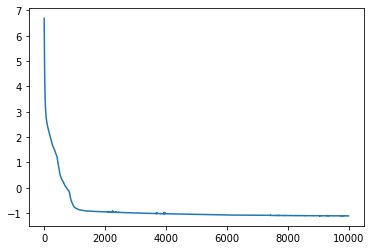

In [35]:
plt.plot(losses)

### Save and load saved network

In [ ]:
# save the network
torch.save(model.state_dict(), 'mdn_model')

In [ ]:
#Load the network
n_input = x.shape[1]
n_output = y.shape[1]
N_HIDDEN = 20
N_GAUSSIANS = 5

network = MDN(n_input=n_input, n_hidden=N_HIDDEN, n_output=n_output, n_gaussians=N_GAUSSIANS)
network.load_state_dict(torch.load('mdn_model'))
network.eval()

print(network)

# Prediction
1. Forward pass of the network with test data
2. Sample the solution

In [ ]:
# Test data
n_samples = 1000
# evenly spaced samples from -10 to 10
x_test_data = np.linspace(-10, 10, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)

In [ ]:
# Forward pass of the network with the test data:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

If we assume that the guassians are not too strongly overlapping, we can take the centre of the highest component. And then sample from the Normal distribution



In [ ]:
def sample_preds(pi, sigmasq, mu):
    N, K = pi.shape
    _, KT = mu.shape
    NO = int(KT / K)
    pred = Variable(torch.zeros(N, NO)) 
    for i in range(N):
        u = np.random.uniform()
        prob_sum = 0
        for k in range(K):
            prob_sum += pi.data[i, k]
            if u < prob_sum:
                # sample from the kth component
                for t in range(NO):
                    sample = np.random.normal(mu.data[i, k*NO+t], np.sqrt(sigmasq.data[i, k]))
                    pred[i, t] = sample
                break
    return pred


In [ ]:
# plot predictions
# plot sampled predictions at each point along x
pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

y_pred = sample_preds(pi_data, sigma_data, mu_data)
plt.figure(figsize=(8, 8))
plt.plot(x,y,'ro', alpha=0.3)
plt.plot(x_test_data,y_pred,'bo', alpha=0.3)
plt.show()

# Backpropagation: How?

# References 
 1. Christopher M. Bishop. Mixed Density Networks (1994). https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf
 2. Lanillos, P., Pages, J. & Cheng, G. (2020). Robot self/other distinction: active inference meets neural networks learning in a mirror. European Conference on Artificial Intelligence (ECAI). https://arxiv.org/abs/2004.05473
 3. https://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/